In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.patheffects as path_effects
import math

# Step 1: Read `Zonal Histogram` and `Legend` CSV files

Two inputs are required:

1. **Zonal histogram**: calculated using the CORINE Landcover and the overlayed vector zones. This layer MUST include a `NAME` field, in addition to the calculated `HISTO_{BAND_NUM}` fields. All other fields are ignored
2. **Corine Landcover Legend (CLC Legend)**: This is a CSV that was included in the original data, and includes all the labels and associated color values. https://land.copernicus.eu/en/products/corine-land-cover, https://www.eea.europa.eu/data-and-maps/data/corine-land-cover-2/corine-land-cover-classes-and/clc_legend.csv

In [42]:
# Step 1: Load CSV files
zonal_histogram = pd.read_csv("data/zonal_histogram_canaries.csv") # Zonal Histogram Output
clc_legend = pd.read_csv("data/clc_legend.csv") # 

In [43]:
zonal_histogram.head()

,fid,NAME,HISTO_1,HISTO_2,HISTO_3,HISTO_4,HISTO_5,HISTO_6,HISTO_7,HISTO_8,...,HISTO_28,HISTO_29,HISTO_30,HISTO_31,HISTO_32,HISTO_33,HISTO_38,HISTO_41,HISTO_42,HISTO_44
0,1,El Hierro,0,412,0,0,0,28,0,0,...,517,716,0,1723,9291,112,0,0,0,106
1,2,Fuerteventura,566,3957,584,122,47,336,283,27,...,69,127,9105,15518,118219,0,34,0,0,448
2,3,Gran Canaria,3811,6233,2045,160,356,472,733,55,...,32116,4692,743,227,47051,114,0,136,0,217
3,4,La Gomera,0,238,0,0,0,36,0,0,...,9520,1015,0,5066,1753,123,0,0,0,77
4,5,La Palma,270,971,160,0,58,109,28,0,...,7193,2448,0,6977,7763,0,0,41,0,115


In [44]:
clc_legend.head()

,GRID_CODE,CLC_CODE,LABEL1,LABEL2,LABEL3,RGB,Color,isNatural
0,1,111,Artificial surfaces,Urban fabric,Continuous urban fabric,230-000-077,NaN,0
1,2,112,Artificial surfaces,Urban fabric,Discontinuous urban fabric,255-000-000,NaN,0
2,3,121,Artificial surfaces,"Industrial, commercial and transport units",Industrial or commercial units,204-077-242,NaN,0
3,4,122,Artificial surfaces,"Industrial, commercial and transport units",Road and rail networks and associated land,204-000-000,NaN,0
4,5,123,Artificial surfaces,"Industrial, commercial and transport units",Port areas,230-204-204,NaN,0


# Step 2: Map the zonal histogram to the CLC legend labels

In [45]:
# Step 2: Reshape Zonal Histogram for easy access
histogram_columns = [col for col in zonal_histogram.columns if col.startswith("HISTO_")]

In [46]:
# Transpose and keep 'NAME' for context
zonal_histogram_long = zonal_histogram.melt(
    id_vars=["NAME"], value_vars=histogram_columns, var_name="HISTO", value_name="PixelCount")

In [47]:
# Extract the numeric part of HISTO (e.g., HISTO_1 -> 1)
zonal_histogram_long["GRID_CODE"] = zonal_histogram_long["HISTO"].str.extract(r"HISTO_(\d+)").astype(int)

In [48]:
# Merge with CLC Legend
zonal_histogram_long = zonal_histogram_long.merge(
    clc_legend[["GRID_CODE", "LABEL1", "LABEL2", "LABEL3"]],
    how="left", on="GRID_CODE"
)

In [49]:
zonal_histogram_long.head()

,NAME,HISTO,PixelCount,GRID_CODE,LABEL1,LABEL2,LABEL3
0,El Hierro,HISTO_1,0,1,Artificial surfaces,Urban fabric,Continuous urban fabric
1,Fuerteventura,HISTO_1,566,1,Artificial surfaces,Urban fabric,Continuous urban fabric
2,Gran Canaria,HISTO_1,3811,1,Artificial surfaces,Urban fabric,Continuous urban fabric
3,La Gomera,HISTO_1,0,1,Artificial surfaces,Urban fabric,Continuous urban fabric
4,La Palma,HISTO_1,270,1,Artificial surfaces,Urban fabric,Continuous urban fabric


# Step 3: Select aggregation level (using label) to be used for analysis 

The CORINE dataset has generally three aggregation levels, ranging from `LABEL1 ` (most coarse) to `LABEL3` (most granular). Naturally, the level determines the number of landcover categories in the resulting plots. 

In [50]:
# Step 3: Select aggregation level (using label)
selected_label = "LABEL2"  # Change to LABEL2 or LABEL3 as needed
zonal_histogram_long["SelectedLabel"] = zonal_histogram_long[selected_label]

In [51]:
# Step 4: Aggregate Data
aggregated_data = zonal_histogram_long.groupby(["NAME", "SelectedLabel"], as_index=False).agg({"PixelCount": "sum"})

In [52]:
# Drop records where PixelCount is 0
aggregated_data = aggregated_data[aggregated_data["PixelCount"] > 0]

In [53]:
# Step 5: Ensure 'PixelPercentage' column exists
if "PixelPercentage" not in aggregated_data.columns:
    total_pixels_by_region = aggregated_data.groupby("NAME")["PixelCount"].transform("sum")
    aggregated_data["PixelPercentage"] = (aggregated_data["PixelCount"] / total_pixels_by_region) * 100

In [54]:
aggregated_data.head(20)

,NAME,SelectedLabel,PixelCount,PixelPercentage
0,El Hierro,Arable land,152,0.567143
2,El Hierro,Forests,4747,17.712026
3,El Hierro,Heterogeneous agricultural areas,7038,26.260214
4,El Hierro,"Industrial, commercial and transport units",28,0.104474
6,El Hierro,Marine waters,106,0.395508
9,El Hierro,Open spaces with little or no vegetation,11126,41.513376
11,El Hierro,Permanent crops,1142,4.261035
12,El Hierro,Scrub and/or herbaceous vegetation associations,2050,7.648968
13,El Hierro,Urban fabric,412,1.537256
14,Fuerteventura,Arable land,6248,3.759258


# Plot Results as a Pie Chart (By Zone)

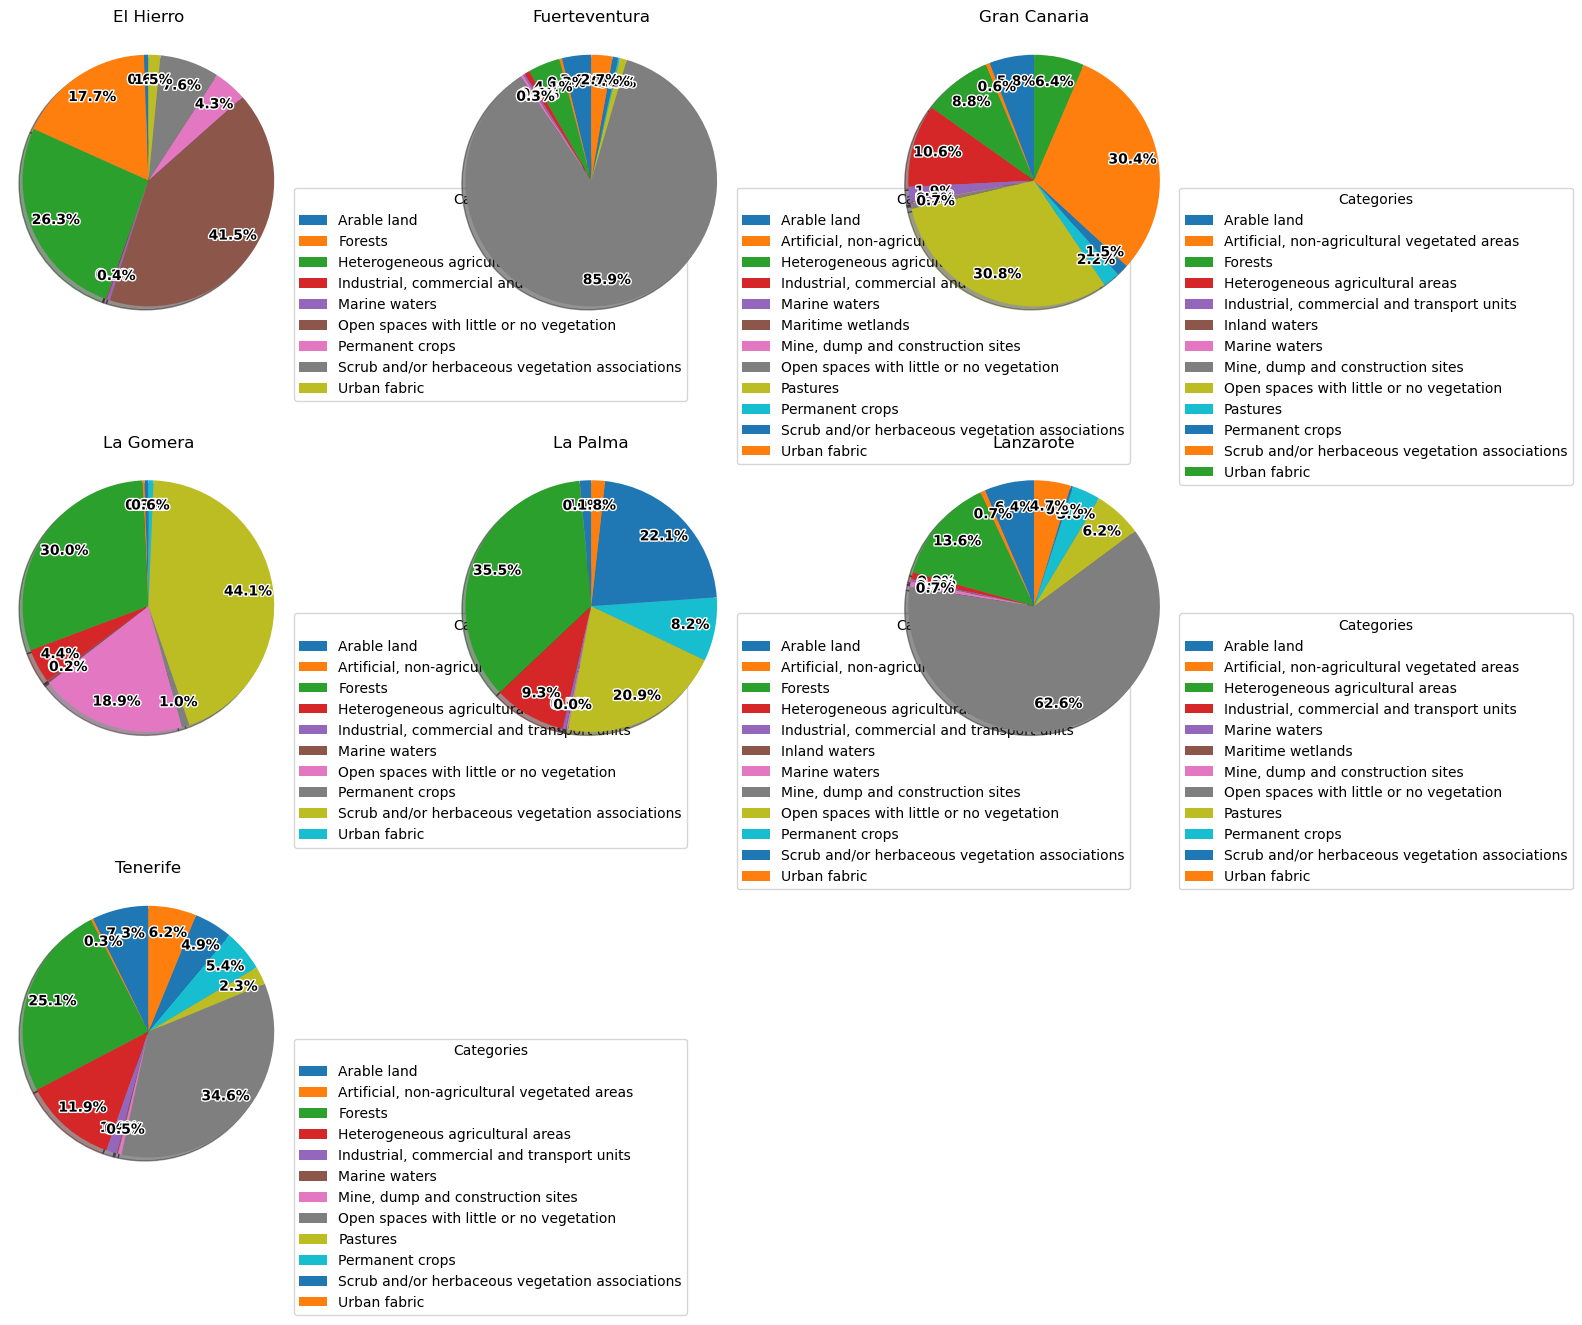

In [55]:
# Step 6: Plot Pie Charts (By Zone)
def plot_pie_charts(aggregated_data, unique_names):
    ncols = 3
    nrows = math.ceil(len(unique_names) / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))
    axes = axes.flatten()

    for idx, name in enumerate(unique_names):
        plot_data = aggregated_data[aggregated_data["NAME"] == name]
        plot_data = plot_data.groupby("SelectedLabel")["PixelCount"].sum()

        wedges, _, autotexts = axes[idx].pie(
            plot_data, autopct='%1.1f%%', startangle=90, pctdistance=0.8, shadow=True
        )
        for autotext in autotexts:
            autotext.set_fontsize(10)
            autotext.set_weight('bold')
            autotext.set_color('black')
            autotext.set_path_effects([path_effects.withStroke(linewidth=2, foreground='white')])

        axes[idx].legend(
            wedges, plot_data.index, title="Categories", loc="upper left", bbox_to_anchor=(1, 0.5), fontsize=10
        )
        axes[idx].set_title(f"{name}", fontsize=12, pad=5)
        axes[idx].axis('equal')

    for idx in range(len(unique_names), len(axes)):
        fig.delaxes(axes[idx])

    plt.subplots_adjust(hspace=0.4, wspace=0.6)
    plt.savefig("output/combined_pie_charts.png", dpi=300, bbox_inches='tight')
    plt.show()

# Plot pie charts
unique_names = aggregated_data["NAME"].unique()
plot_pie_charts(aggregated_data, unique_names)

# Stacked Bar Chart (using Matplotlib); exact colors from CORINE Legend

/tmp/ipykernel_36997/461237931.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



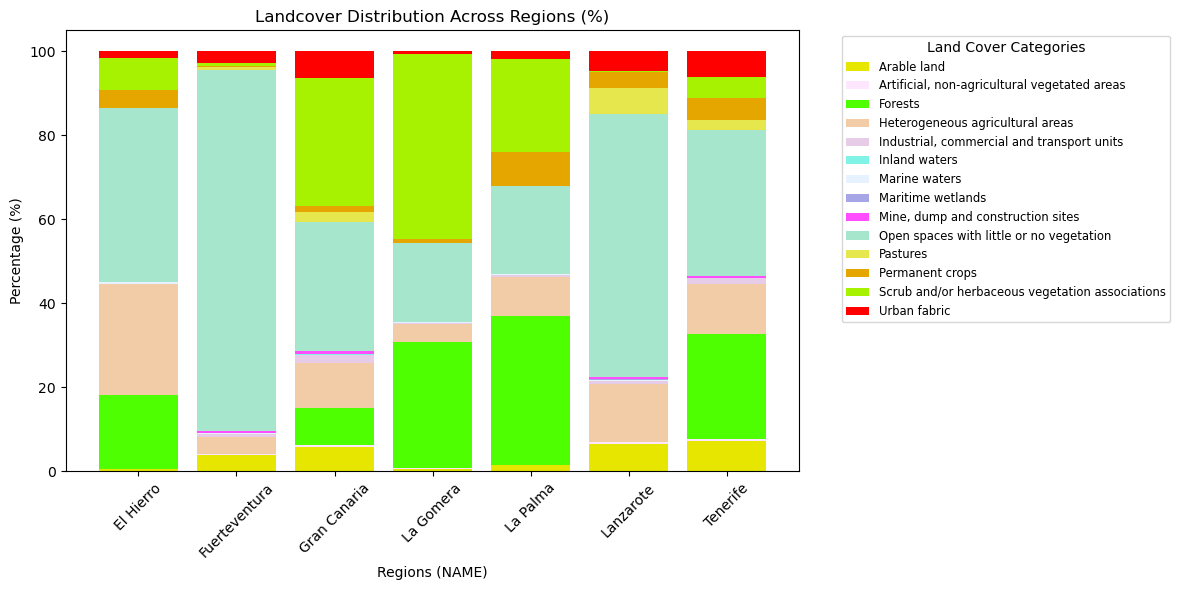

In [56]:
# Step 7: Plot Stacked Bar Chart (Matplotlib)
def plot_stacked_bar_chart(aggregated_data, clc_legend, selected_label):
    unique_labels = aggregated_data["SelectedLabel"].unique()
    filtered_legend = clc_legend[clc_legend[selected_label].isin(unique_labels)]

    def parse_rgb(rgb_str):
        return tuple(int(c) / 255.0 for c in rgb_str.split("-"))
    
    filtered_legend["RGB_Tuple"] = filtered_legend["RGB"].apply(parse_rgb)
    label_to_color = dict(zip(filtered_legend[selected_label], filtered_legend["RGB_Tuple"]))

    pivot_data_percentage = aggregated_data.pivot(
        index="NAME", columns="SelectedLabel", values="PixelPercentage"
    ).fillna(0)

    colors = [label_to_color[label] for label in pivot_data_percentage.columns]

    fig, ax = plt.subplots(figsize=(12, 6))
    bottoms = pd.Series([0] * len(pivot_data_percentage), index=pivot_data_percentage.index)

    for idx, col in enumerate(pivot_data_percentage.columns):
        ax.bar(
            pivot_data_percentage.index, pivot_data_percentage[col],
            label=col, bottom=bottoms, color=colors[idx]
        )
        bottoms += pivot_data_percentage[col]

    plt.ylabel("Percentage (%)")
    plt.xlabel("Regions (NAME)")
    plt.title("Landcover Distribution Across Regions (%)")
    plt.legend(title="Land Cover Categories", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.savefig("output/stacked_bar_chart.png", dpi=300)
    plt.show()

# Plot stacked bar chart
plot_stacked_bar_chart(aggregated_data, clc_legend, selected_label)

# Stacked Bar Chart (using Plotly)

In [57]:
# Step 8: Plot Stacked Bar Chart (Plotly)
def plot_stacked_bar_chart_plotly(aggregated_data, clc_legend, selected_label):
    unique_labels = aggregated_data["SelectedLabel"].unique()
    filtered_legend = clc_legend[clc_legend[selected_label].isin(unique_labels)]

    def parse_rgb(rgb_str):
        return f"rgb({','.join(rgb_str.split('-'))})"

    filtered_legend["RGB_Tuple"] = filtered_legend["RGB"].apply(parse_rgb)
    label_to_color = dict(zip(filtered_legend[selected_label], filtered_legend["RGB_Tuple"]))

    pivot_data_percentage = aggregated_data.pivot(
        index="NAME", columns="SelectedLabel", values="PixelPercentage"
    ).fillna(0)

    fig = go.Figure()

    for label in pivot_data_percentage.columns:
        fig.add_trace(go.Bar(
            x=pivot_data_percentage.index, y=pivot_data_percentage[label],
            name=label, marker_color=label_to_color[label],
            hovertemplate="%{y:.2f}%",  # Format hover label with 1 decimal place and percentage sign
        ))

    fig.update_layout(
        height=700, width=1000, barmode='stack', title="Landscape Percentage Distribution Across Regions",
        xaxis_title="Regions (NAME)", yaxis_title="Percentage (%)", legend_title="Land Cover Categories",
        hovermode="x unified", template="plotly_white"
    )

    fig.show()

# Plot stacked bar chart (Plotly)
plot_stacked_bar_chart_plotly(aggregated_data, clc_legend, selected_label)

/tmp/ipykernel_36997/1236631639.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Export Plotly Plot as HTML (Optional)

/tmp/ipykernel_36997/2401152041.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



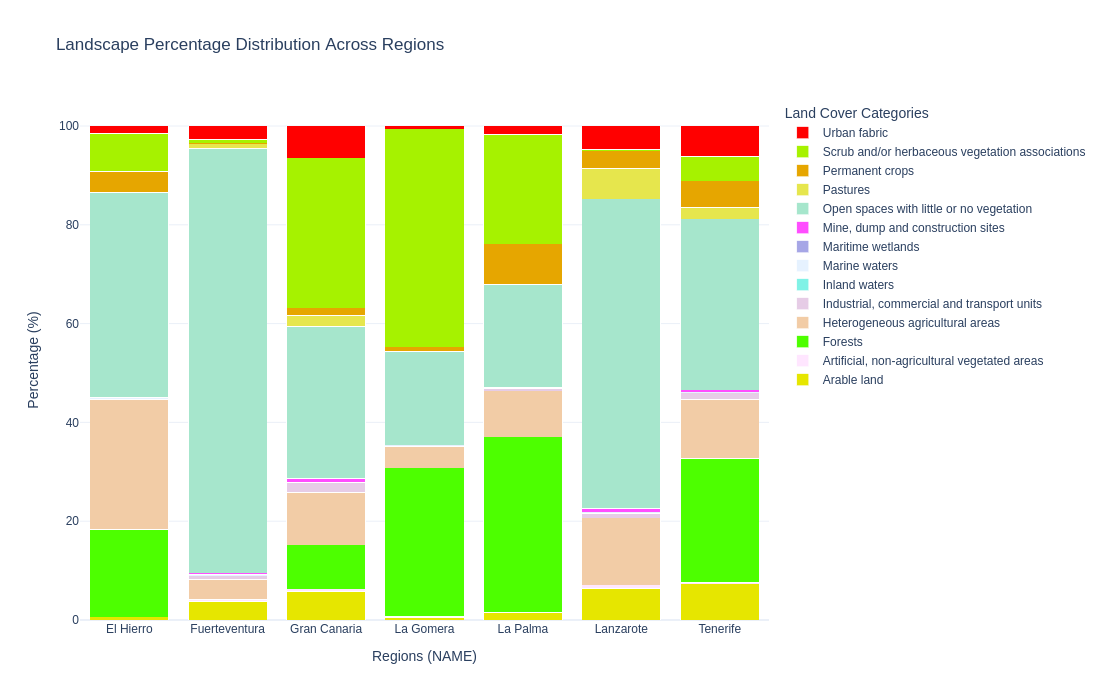

In [62]:
# Step 8: Plot Stacked Bar Chart (Plotly)
# def plot_stacked_bar_chart_plotly(aggregated_data, clc_legend, selected_label):
unique_labels = aggregated_data["SelectedLabel"].unique()
filtered_legend = clc_legend[clc_legend[selected_label].isin(unique_labels)]

def parse_rgb(rgb_str):
    return f"rgb({','.join(rgb_str.split('-'))})"

filtered_legend["RGB_Tuple"] = filtered_legend["RGB"].apply(parse_rgb)
label_to_color = dict(zip(filtered_legend[selected_label], filtered_legend["RGB_Tuple"]))

pivot_data_percentage = aggregated_data.pivot(
    index="NAME", columns="SelectedLabel", values="PixelPercentage"
).fillna(0)

fig = go.Figure()

for label in pivot_data_percentage.columns:
    fig.add_trace(go.Bar(
        x=pivot_data_percentage.index, y=pivot_data_percentage[label],
        name=label, marker_color=label_to_color[label],
        hovertemplate="%{y:.2f}%",  # Format hover label with 1 decimal place and percentage sign
    ))

fig.update_layout(
    height=700, width=1000, barmode='stack', title="Landscape Percentage Distribution Across Regions",
    xaxis_title="Regions (NAME)", yaxis_title="Percentage (%)", legend_title="Land Cover Categories",
    hovermode="x unified", template="plotly_white"
)

# fig.update_layout(
#     autosize=True,
#     margin=dict(l=0, r=0, b=0, t=0),
#     title="Your Plot Title",
#     showlegend=False
# )


fig.show()

# # Plot stacked bar chart (Plotly)
# plot_stacked_bar_chart_plotly(aggregated_data, clc_legend, selected_label)

In [63]:
import plotly.io as pio
pio.write_html(fig, file='plot.html', auto_open=True)